In [1]:
import duckdb
import seaborn as sns
import matplotlib.pyplot as plt
import textwrap

In [2]:
conn = duckdb.connect('mimic_new.db', read_only = False)

conn.execute("""
    CREATE OR REPLACE TABLE ADMISSIONS AS
    SELECT * FROM read_csv_auto('ADMISSIONS.csv');
""")

conn.execute("""
    CREATE OR REPLACE TABLE ICUSTAYS AS
    SELECT * FROM read_csv_auto('ICUSTAYS.csv');
""")

conn.execute("""
    CREATE OR REPLACE TABLE PATIENTS AS
    SELECT * FROM read_csv_auto('PATIENTS.csv');
""")

conn.execute("""
    CREATE OR REPLACE TABLE PROCEDURES_ICD AS
    SELECT * FROM read_csv_auto('PROCEDURES_ICD.csv');
""")

conn.execute("""
    CREATE OR REPLACE TABLE D_ICD_PROCEDURES AS
    SELECT * FROM read_csv_auto('D_ICD_PROCEDURES.csv');
""")

conn.execute("""
    CREATE OR REPLACE TABLE DRGCODES AS
    SELECT * FROM read_csv_auto('DRGCODES.csv');
""")

conn.execute("""
    CREATE OR REPLACE TABLE PRESCRIPTIONS AS
    SELECT * FROM read_csv_auto('PRESCRIPTIONS.csv');
""")

conn.sql('SHOW TABLES')

┌──────────────────┐
│       name       │
│     varchar      │
├──────────────────┤
│ ADMISSIONS       │
│ DRGCODES         │
│ D_ICD_PROCEDURES │
│ ICUSTAYS         │
│ PATIENTS         │
│ PRESCRIPTIONS    │
│ PROCEDURES_ICD   │
└──────────────────┘

**Part 1**

**Question 1**

In [17]:
# Create a summary of type of drugs and their total amount used by ethnicity. Report the top usage in each ethnicity group.
df = conn.sql("""
SELECT
    ADMISSIONS.ethnicity,
    PRESCRIPTIONS.drug_type,
    COUNT(*) AS drug_amount
FROM
    PRESCRIPTIONS
JOIN
    ADMISSIONS
    ON PRESCRIPTIONS.HADM_ID = ADMISSIONS.HADM_ID
GROUP BY
    ADMISSIONS.ethnicity, PRESCRIPTIONS.drug_type
ORDER BY
    ADMISSIONS.ethnicity, drug_amount DESC;
""").df()

In [7]:
df

,ethnicity,drug_type,drug_amount
0,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,MAIN,200
1,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,BASE,80
2,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,ADDITIVE,2
3,ASIAN,MAIN,121
4,ASIAN,BASE,56
5,BLACK/AFRICAN AMERICAN,MAIN,476
6,BLACK/AFRICAN AMERICAN,BASE,169
7,HISPANIC OR LATINO,MAIN,226
8,HISPANIC OR LATINO,BASE,96
9,HISPANIC/LATINO - PUERTO RICAN,MAIN,860


In [24]:
top_drugs = (df.sort_values(['ethnicity', 'drug_amount'], ascending=[True, False])
  .groupby('ethnicity')
  .head(1)
  .sort_values('drug_amount', ascending=False)
  .reset_index(drop=True)
)
print(top_drugs)

                                           ethnicity drug_type  drug_amount
0                                              WHITE      MAIN         5420
1                     HISPANIC/LATINO - PUERTO RICAN      MAIN          860
2                             BLACK/AFRICAN AMERICAN      MAIN          476
3                              UNKNOWN/NOT SPECIFIED      MAIN          245
4                                 HISPANIC OR LATINO      MAIN          226
5  AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...      MAIN          200
6                                              ASIAN      MAIN          121
7                                   UNABLE TO OBTAIN      MAIN           89
8                                              OTHER      MAIN           72


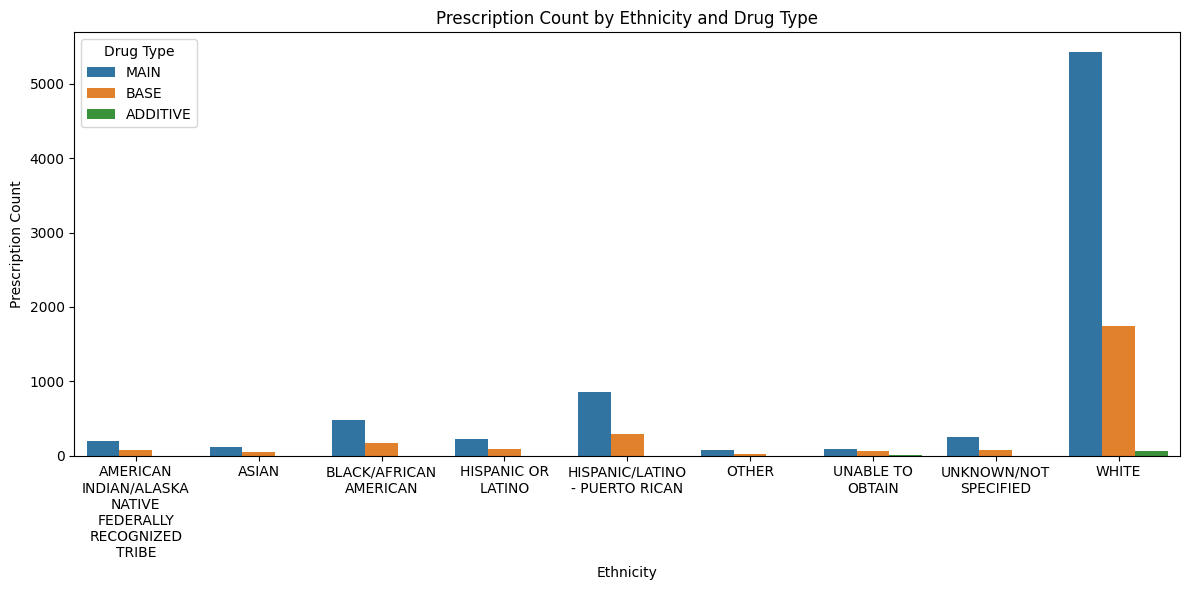

In [10]:
df['ethnicity_wrapped'] = df['ethnicity'].apply(lambda x: '\n'.join(textwrap.wrap(x, 15)))

plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='ethnicity_wrapped', y='drug_amount', hue='drug_type')

plt.title('Prescription Count by Ethnicity and Drug Type')
plt.xlabel('Ethnicity')
plt.ylabel('Prescription Count')
plt.legend(title='Drug Type')
plt.tight_layout()
plt.show()

In [11]:
# Creating table for NoSQL
df_nosql = conn.sql("""
SELECT
    ADMISSIONS.ethnicity,
    PRESCRIPTIONS.drug_type,
FROM
    PRESCRIPTIONS
JOIN
    ADMISSIONS
    ON PRESCRIPTIONS.HADM_ID = ADMISSIONS.HADM_ID
""").df()

In [13]:
df_nosql

,ethnicity,drug_type
0,WHITE,MAIN
1,WHITE,MAIN
2,WHITE,MAIN
3,WHITE,MAIN
4,WHITE,MAIN
...,...,...
10393,WHITE,MAIN
10394,WHITE,MAIN
10395,WHITE,BASE
10396,WHITE,BASE


In [10]:
df_nosql.to_csv('drug_usage_raw.csv', index=False)

**Question 2**

In [25]:
# Create a summary of procedures performed on patients by age groups (<=19, 20-49, 50-79, >80).
# Report the top three procedures, along with the name of the procedures, performed in each age group.
df_age_groups = conn.sql("""
WITH patient_age AS (
  SELECT
    PATIENTS.subject_id,
    ADMISSIONS.hadm_id,
    D_ICD_PROCEDURES.icd9_code,
    D_ICD_PROCEDURES.short_title,
    EXTRACT(YEAR FROM ADMISSIONS.admittime) - EXTRACT(YEAR FROM PATIENTS.dob) AS age
  FROM
    PATIENTS
  JOIN
    ADMISSIONS ON PATIENTS.subject_id = ADMISSIONS.subject_id
  JOIN
    PROCEDURES_ICD ON ADMISSIONS.hadm_id = PROCEDURES_ICD.hadm_id
  JOIN
    D_ICD_PROCEDURES ON PROCEDURES_ICD.icd9_code = D_ICD_PROCEDURES.icd9_code
),
age_grouped AS (
  SELECT
    CASE
      WHEN age <= 19 THEN '0-19'
      WHEN age BETWEEN 20 AND 49 THEN '20-49'
      WHEN age BETWEEN 50 AND 79 THEN '50-79'
      ELSE '>80'
    END AS age_group,
    short_title, COUNT(*) AS procedure_num
  FROM patient_age
  GROUP BY age_group, short_title
)
SELECT
  age_group,
  short_title,
  procedure_num
FROM age_grouped
ORDER BY age_group, procedure_num DESC;
""").df()

In [26]:
df_age_groups

,age_group,short_title,procedure_num
0,0-19,Venous cath NEC,2
1,0-19,Vertebral fx repair,1
2,0-19,Interruption vena cava,1
3,0-19,Spinal tap,1
4,0-19,Percu endosc gastrostomy,1
...,...,...,...
221,>80,Total hip replacement,1
222,>80,Cholangiogram NEC,1
223,>80,Manual reduc rect prolap,1
224,>80,Intraoper cholangiogram,1


In [27]:
top3 = df_age_groups.groupby('age_group').head(3).reset_index(drop=True)
print(top3)

   age_group               short_title  procedure_num
0       0-19           Venous cath NEC              2
1       0-19       Vertebral fx repair              1
2       0-19    Interruption vena cava              1
3      20-49           Venous cath NEC              9
4      20-49   Entral infus nutrit sub              7
5      20-49  Percu abdominal drainage              6
6      50-79           Venous cath NEC             25
7      50-79   Entral infus nutrit sub             22
8      50-79   Packed cell transfusion             13
9        >80           Venous cath NEC             20
10       >80   Packed cell transfusion             13
11       >80  Insert endotracheal tube              8


In [28]:
df_age_groups_nosql = conn.sql("""
WITH patient_age AS (
  SELECT
    PATIENTS.subject_id,
    ADMISSIONS.hadm_id,
    D_ICD_PROCEDURES.icd9_code,
    D_ICD_PROCEDURES.short_title,
    EXTRACT(YEAR FROM ADMISSIONS.admittime) - EXTRACT(YEAR FROM PATIENTS.dob) AS age
  FROM
    PATIENTS
  JOIN
    ADMISSIONS ON PATIENTS.subject_id = ADMISSIONS.subject_id
  JOIN
    PROCEDURES_ICD ON ADMISSIONS.hadm_id = PROCEDURES_ICD.hadm_id
  JOIN
    D_ICD_PROCEDURES ON PROCEDURES_ICD.icd9_code = D_ICD_PROCEDURES.icd9_code
)
SELECT short_title, age
FROM patient_age
""").df()

In [29]:
df_age_groups_nosql.head()

,short_title,age
0,PTCA,300
1,Transplant cadaver donor,44
2,Other brain dx procedure,20
3,Adm inhal nitric oxide,44
4,Inject/infus nesiritide,44


In [30]:
df_age_groups_nosql.to_csv('df_age_groups_nosql.csv', index=False)

**Question 3**

In [31]:
# How long do patients stay in the ICU? Is there a difference in the ICU length of stay among gender or ethnicity?
df_ICU_stay = conn.sql("""
SELECT
  ICUSTAYS.subject_id,
  ADMISSIONS.ethnicity,
  PATIENTS.gender,
  ROUND(ICUSTAYS.los,2) AS icu_length_of_stay
FROM
  ICUSTAYS
JOIN ADMISSIONS ON ICUSTAYS.hadm_id = ADMISSIONS.hadm_id
JOIN PATIENTS ON ADMISSIONS.subject_id = PATIENTS.subject_id
""").df()

In [32]:
df_ICU_stay

,subject_id,ethnicity,gender,icu_length_of_stay
0,10006,BLACK/AFRICAN AMERICAN,F,1.63
1,10011,UNKNOWN/NOT SPECIFIED,F,13.85
2,10013,UNKNOWN/NOT SPECIFIED,F,2.65
3,10017,WHITE,F,2.14
4,10019,WHITE,M,1.29
...,...,...,...,...
131,40304,WHITE,M,1.15
132,42281,HISPANIC OR LATINO,F,3.78
133,43735,WHITE,M,1.04
134,43746,WHITE,F,1.97


            mean       std  median
gender                            
F       5.540635  7.818025    2.41
M       3.513973  4.176268    1.93
                                                         mean        std  \
ethnicity                                                                  
AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNI...  11.335000  14.248202   
ASIAN                                                3.890000   4.567910   
BLACK/AFRICAN AMERICAN                               7.675714  10.920249   
HISPANIC OR LATINO                                   7.463333   6.579911   
HISPANIC/LATINO - PUERTO RICAN                       3.244000   3.259647   
OTHER                                                0.926667   0.911501   
UNABLE TO OBTAIN                                    13.360000        NaN   
UNKNOWN/NOT SPECIFIED                                4.924545   4.820200   
WHITE                                                4.130870   6.139099   

                       

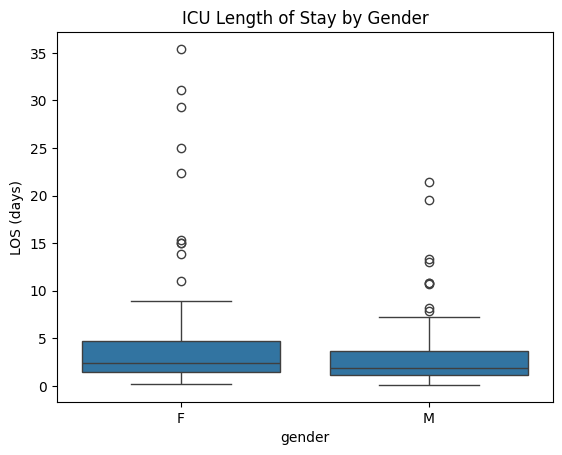

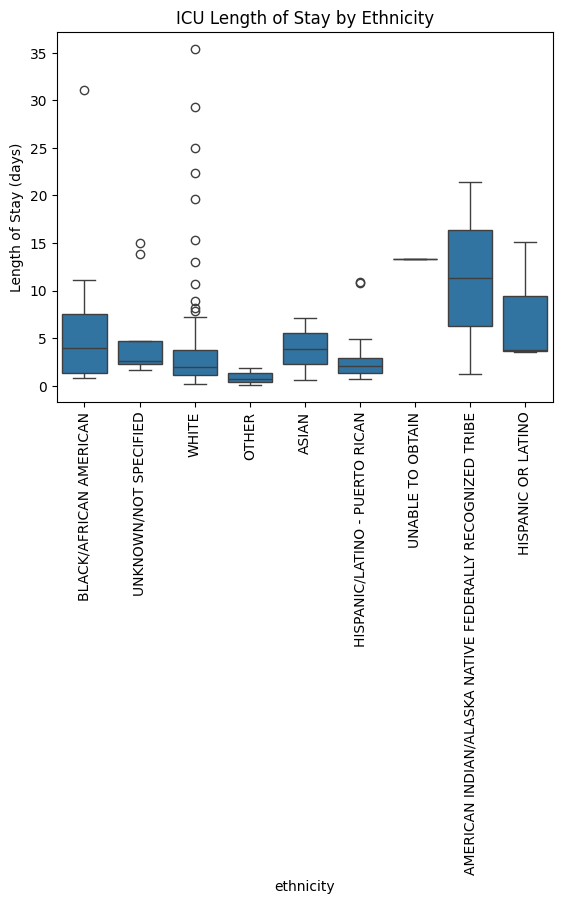

In [19]:
print(df_ICU_stay.groupby("gender")["icu_length_of_stay"].agg(["mean", "std", "median"]))

print(df_ICU_stay.groupby("ethnicity")["icu_length_of_stay"].agg(["mean", "std", "median"]))

sns.boxplot(data=df_ICU_stay, x="gender", y="icu_length_of_stay")
plt.title("ICU Length of Stay by Gender")
plt.ylabel("LOS (days)")
plt.show()

sns.boxplot(data=df_ICU_stay, x="ethnicity", y="icu_length_of_stay")
plt.xticks(rotation=90)
plt.title("ICU Length of Stay by Ethnicity")
plt.ylabel("Length of Stay (days)")
plt.show()

In [20]:
ICU_stay_nosql = conn.sql("""
SELECT
  ICUSTAYS.subject_id,
  ADMISSIONS.ethnicity,
  PATIENTS.gender,
  ROUND(ICUSTAYS.los, 2) AS icu_length_of_stay
FROM
  ICUSTAYS
JOIN ADMISSIONS ON ICUSTAYS.hadm_id = ADMISSIONS.hadm_id
JOIN PATIENTS ON ADMISSIONS.subject_id = PATIENTS.subject_id
""").df()

In [21]:
ICU_stay_nosql.to_csv('ICU_stay_nosql.csv', index=False)

In [22]:
conn.close()